## Importing relevant packages

In [ ]:
!pip install phik==0.10.0 #for phi k correlation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install dexplot #for EDA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pygam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import phik
import dexplot as dxp
import pygam
import optuna
import shap
import catboost

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from phik.report import plot_correlation_matrix
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

## Load the dataset

In [ ]:
fashion = pd.read_csv('store.csv')
fashion.head()

,ZIP_CODE,FRE,MON,CC_CARD,AVRG,PC_CALC20,PSWEATERS,PKNIT_TOPS,PKNIT_DRES,PBLOUSES,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
0,1001,2,368.46,0,184.23,11,0.18,0.00,0.00,0.30,...,N,0,5,0,0.00,31.81,111.00,10,0.00,0
1,1028,4,258.00,1,64.50,11,0.26,0.16,0.00,0.00,...,Y,0,4,2,50.00,32.72,43.50,10,0.03,1
2,1056,2,77.00,0,38.50,11,1.00,0.00,0.00,0.00,...,N,0,4,0,0.00,100.00,68.60,16,0.00,0
3,1118,8,846.06,1,105.75,11,0.38,0.00,0.05,0.06,...,Y,0,9,6,66.67,23.27,26.96,10,0.00,0
4,1107,1,87.44,0,87.44,11,0.20,0.20,0.00,0.00,...,Y,0,0,0,0.00,28.52,24.50,20,0.00,0


In [ ]:
fashion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21740 entries, 0 to 21739
Data columns (total 48 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ZIP_CODE      21740 non-null  int64  
 1   FRE           21740 non-null  int64  
 2   MON           21740 non-null  float64
 3   CC_CARD       21740 non-null  int64  
 4   AVRG          21740 non-null  float64
 5   PC_CALC20     21740 non-null  int64  
 6   PSWEATERS     21740 non-null  float64
 7   PKNIT_TOPS    21740 non-null  float64
 8   PKNIT_DRES    21740 non-null  float64
 9   PBLOUSES      21740 non-null  float64
 10  PJACKETS      21740 non-null  float64
 11  PCAR_PNTS     21740 non-null  float64
 12  PCAS_PNTS     21740 non-null  float64
 13  PSHIRTS       21740 non-null  float64
 14  PDRESSES      21740 non-null  float64
 15  PSUITS        21740 non-null  float64
 16  POUTERWEAR    21740 non-null  float64
 17  PJEWELRY      21740 non-null  float64
 18  PFASHION      21740 non-nu

In [ ]:
# Encode data in VALPHON using dummy encoding
fashion['VALPHON'] = fashion['VALPHON'].map({'Y': 1, 'N': 0})

This dataset contains 48 columns and 21,740 observations; each observation represents a data of a fashion store's customers and whether s/he responded to the marketing campaign or not. The response variable is `RESP` with 1 means that the customer responded to store's promotion, and 0 means that the customer did not respond to the promotion.

The breakdown of predictors based on its data type is as follows:

1.   12 discrete variables
2.   31 continuous variables
3. 3 binary variables
4. 1 categorical variable

In [ ]:
discrete = ['ZIP_CODE', 'FRE', 'PC_CALC20', 'PROMOS', 'DAYS', 'FREDAYS', 'CLASSES', 'COUPONS', 'STYLES', 'STORES', 'MAILED', 'RESPONDED']

continuous = ['MON', 'AVRG', 'PSWEATERS', 'PKNIT_TOPS', 'PKNIT_DRES', 'PBLOUSES', 'PJACKETS', 'PCAR_PNTS',
              'PCAS_PNTS', 'PSHIRTS', 'PDRESSES', 'PSUITS', 'POUTERWEAR', 'PJEWELRY', 'PFASHION', 'PLEGWEAR',
              'PCOLLSPND', 'AMSPEND', 'PSSPEND', 'CCSPEND', 'AXSPEND', 'TMONSPEND', 'OMONSPEND', 'SMONSPEND',
              'PREVPD', 'GMP', 'MARKDOWN', 'RESPONSERATE', 'HI', 'LTFREDAY', 'PERCRET']

binary = ['CC_CARD', 'VALPHON', 'WEB']

categorical = ['CLUSTYPE']

response = ['RESP']

In [ ]:
# Check the proportion of 0 and 1 in the response
fashion[response].value_counts(normalize = True)

RESP
0       0.833901
1       0.166099
dtype: float64

### Train - test split

Since the proportion of successful marketing promotion to unsuccessful is imbalanced, with only 16.61% observations being successful (`RESP` = 1), we want to split the data while preserving the same proportions of data in each class.

In [ ]:
index_train, index_test = train_test_split(fashion.index, train_size=0.8, random_state=10, stratify = fashion['RESP'])

train_fashion = fashion.loc[index_train, :].copy()
test_fashion = fashion.loc[index_test, :].copy()

In [ ]:
# Check the proportion of RESP in training dataset

train_fashion[response].value_counts(normalize = True)

RESP
0       0.833889
1       0.166111
dtype: float64

## EDA


### 1. Discrete predictors

In [ ]:
# Check descriptive statistics for discrete predictors
# No missing values and values outside range, however there are outliers

train_fashion[discrete].describe().round(4)

,ZIP_CODE,FRE,PC_CALC20,PROMOS,DAYS,FREDAYS,CLASSES,COUPONS,STYLES,STORES,MAILED,RESPONDED
count,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000
mean,48957.3048,5.0511,12.5614,11.5163,436.2873,171.1805,7.1194,0.7459,17.1261,2.3458,4.6385,1.1824
std,24120.9345,6.4630,2.4551,7.1495,193.3437,146.4701,5.3367,1.6870,24.4493,1.6120,3.5495,1.8301
min,0.0000,1.0000,11.0000,0.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000
25%,30341.0000,1.0000,11.0000,5.0000,286.0000,67.0000,3.0000,0.0000,4.0000,1.0000,1.0000,0.0000
50%,48336.0000,3.0000,11.0000,12.0000,443.0000,124.0000,5.0000,0.0000,9.0000,2.0000,4.0000,0.0000
75%,67010.0000,6.0000,16.0000,17.0000,629.0000,230.6600,10.0000,1.0000,20.0000,3.0000,8.0000,2.0000
max,99687.0000,115.0000,19.0000,38.0000,702.0000,702.0000,35.0000,32.0000,689.0000,19.0000,11.0000,11.0000


In [ ]:
skew_disc = list(train_fashion[discrete].skew().round(4))
kurt_disc = list(train_fashion[discrete].kurtosis().round(4))

disc_info = pd.DataFrame(zip(skew_disc, kurt_disc), columns=['Skewness', 'Kurtosis'], index = discrete)
disc_info

,Skewness,Kurtosis
ZIP_CODE,0.0155,-0.8094
FRE,4.2138,29.8248
PC_CALC20,1.0411,-0.6206
PROMOS,0.1610,-0.9149
DAYS,-0.2349,-1.1624
FREDAYS,1.6000,2.3988
CLASSES,1.3113,1.6491
COUPONS,4.4659,32.6131
STYLES,5.7854,73.5118
STORES,2.2303,8.2153


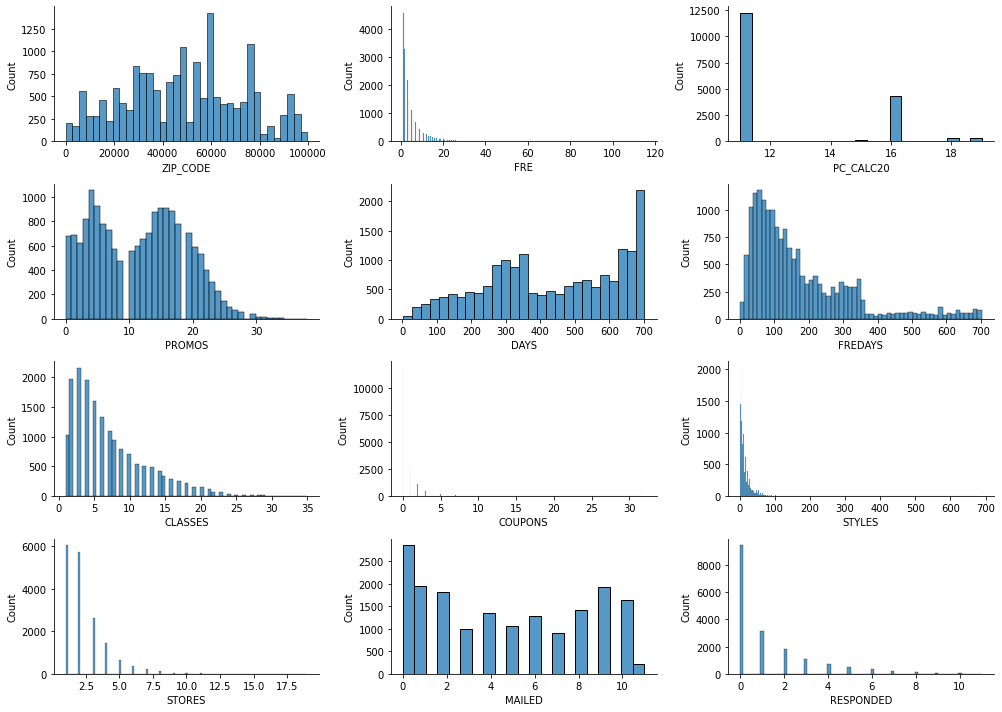

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(14, 10))

for i, ax in enumerate(fig.axes):
    sns.histplot(train_fashion[discrete].iloc[:,i], ax=ax)

sns.despine()
plt.tight_layout()
plt.show()

### 2. Continuous predictors

In [ ]:
# Check descriptive statistics for discrete predictors
# No missing values and values outside range, however there are outliers

train_fashion[continuous].describe().round(4)

,MON,AVRG,PSWEATERS,PKNIT_TOPS,PKNIT_DRES,PBLOUSES,PJACKETS,PCAR_PNTS,PCAS_PNTS,PSHIRTS,...,TMONSPEND,OMONSPEND,SMONSPEND,PREVPD,GMP,MARKDOWN,RESPONSERATE,HI,LTFREDAY,PERCRET
count,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,...,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000,17392.0000
mean,470.9297,113.9954,0.2118,0.0274,0.0413,0.0931,0.1361,0.0865,0.0694,0.0667,...,89.4351,31.6978,221.7162,41.3246,0.5220,0.1866,17.1255,37.9324,80.3037,0.1312
std,641.5078,87.9048,0.2297,0.0695,0.1103,0.1362,0.1833,0.1412,0.1329,0.1176,...,183.6950,95.7011,365.1232,106.6741,0.1431,0.1292,24.5132,28.0492,78.6319,0.5928
min,0.9900,0.4900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0500,0.0900,0.0000
25%,134.9900,60.9800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.4600,0.0800,0.0000,18.4875,25.0000,0.0000
50%,262.1200,92.1950,0.1600,0.0000,0.0000,0.0500,0.0400,0.0000,0.0000,0.0000,...,0.0000,0.0000,107.9550,0.0000,0.5500,0.1800,0.0000,29.7250,52.3150,0.0000
75%,563.4425,139.8075,0.3100,0.0300,0.0200,0.1400,0.2300,0.1300,0.0900,0.1000,...,108.9650,0.0000,286.5925,0.0000,0.6200,0.2800,28.5700,50.0000,107.0000,0.0900
max,22511.4900,1919.8800,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,5562.4600,2189.0000,13224.0700,1919.8800,0.8900,0.9500,100.0000,200.0000,364.0000,40.9200


In [ ]:
# Check skewness and kurtosis
# Almost all variables are right skewed

skew_cont = list(train_fashion[continuous].skew().round(4))
kurt_cont = list(train_fashion[continuous].kurtosis().round(4))

cont_info = pd.DataFrame(zip(skew_cont, kurt_cont), columns=['Skewness', 'Kurtosis'], index = continuous)
cont_info

,Skewness,Kurtosis
MON,7.0641,129.6889
AVRG,3.6814,31.8600
PSWEATERS,1.5134,2.2864
PKNIT_TOPS,6.1606,60.1322
PKNIT_DRES,4.4911,25.6006
PBLOUSES,2.6896,10.6466
PJACKETS,1.5521,2.4989
PCAR_PNTS,2.4623,8.0406
PCAS_PNTS,3.0479,11.9604
PSHIRTS,2.9351,12.3505


### 3. Binary predictors

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


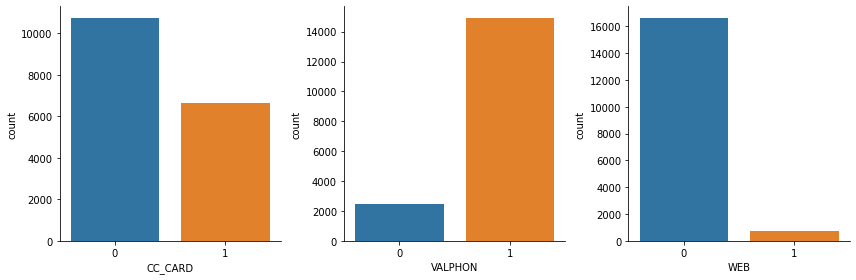

In [ ]:
# There is high proportion of 1 in VALPHONE and 0 in WEB

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(fig.axes):
    sns.countplot(train_fashion[binary].iloc[:,i], ax=ax)

sns.despine()
plt.tight_layout()
plt.show()

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


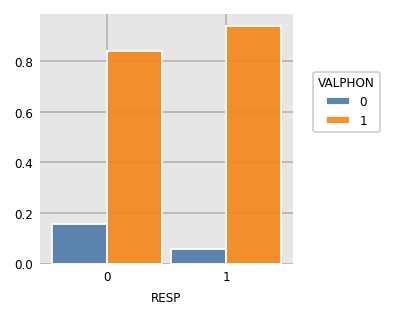

In [ ]:
# Plot the proportion of VALPHON based on each class of RESP

dxp.count('RESP', data=train_fashion, split='VALPHON', normalize='RESP')

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.


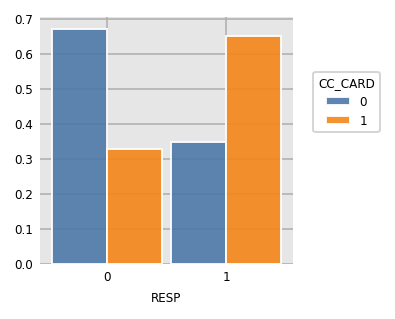

In [ ]:
dxp.count('RESP', data=train_fashion, split='CC_CARD', normalize='RESP')

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.


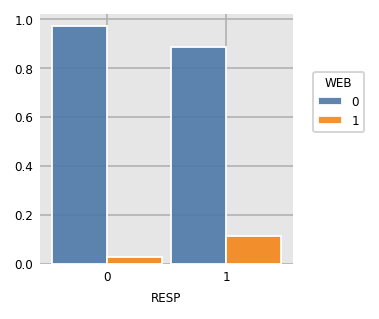

In [ ]:
dxp.count('RESP', data=train_fashion, split='WEB', normalize='RESP')

### 4. Categorical variable

In [ ]:
# CLUSTYPE is a variable with high-cardinality

train_fashion[categorical].value_counts(normalize = True).round(4)

CLUSTYPE
10          0.1230
1           0.0941
4           0.0784
16          0.0665
8           0.0510
15          0.0453
11          0.0444
18          0.0430
5           0.0430
38          0.0399
23          0.0396
3           0.0316
12          0.0310
6           0.0285
25          0.0214
20          0.0187
35          0.0163
24          0.0160
22          0.0128
50          0.0126
2           0.0114
28          0.0113
32          0.0109
39          0.0108
40          0.0090
17          0.0090
7           0.0084
14          0.0077
46          0.0068
45          0.0064
13          0.0063
42          0.0059
30          0.0057
36          0.0053
41          0.0049
37          0.0030
29          0.0028
34          0.0025
48          0.0022
21          0.0022
31          0.0020
0           0.0016
43          0.0013
47          0.0013
9           0.0011
27          0.0010
49          0.0007
26          0.0006
33          0.0003
19          0.0003
44          0.0001
dtype: float64

In [ ]:
train_fashion[categorical].nunique()

CLUSTYPE    51
dtype: int64

### 5. Bivariate EDA

interval columns not set, guessing: ['ZIP_CODE', 'FRE', 'MON', 'CC_CARD', 'AVRG', 'PC_CALC20', 'PSWEATERS', 'PKNIT_TOPS', 'PKNIT_DRES', 'PBLOUSES', 'PJACKETS', 'PCAR_PNTS', 'PCAS_PNTS', 'PSHIRTS', 'PDRESSES', 'PSUITS', 'POUTERWEAR', 'PJEWELRY', 'PFASHION', 'PLEGWEAR', 'PCOLLSPND', 'AMSPEND', 'PSSPEND', 'CCSPEND', 'AXSPEND', 'TMONSPEND', 'OMONSPEND', 'SMONSPEND', 'PREVPD', 'GMP', 'PROMOS', 'DAYS', 'FREDAYS', 'MARKDOWN', 'CLASSES', 'COUPONS', 'STYLES', 'STORES', 'VALPHON', 'WEB', 'MAILED', 'RESPONDED', 'RESPONSERATE', 'HI', 'LTFREDAY', 'CLUSTYPE', 'PERCRET', 'RESP']


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


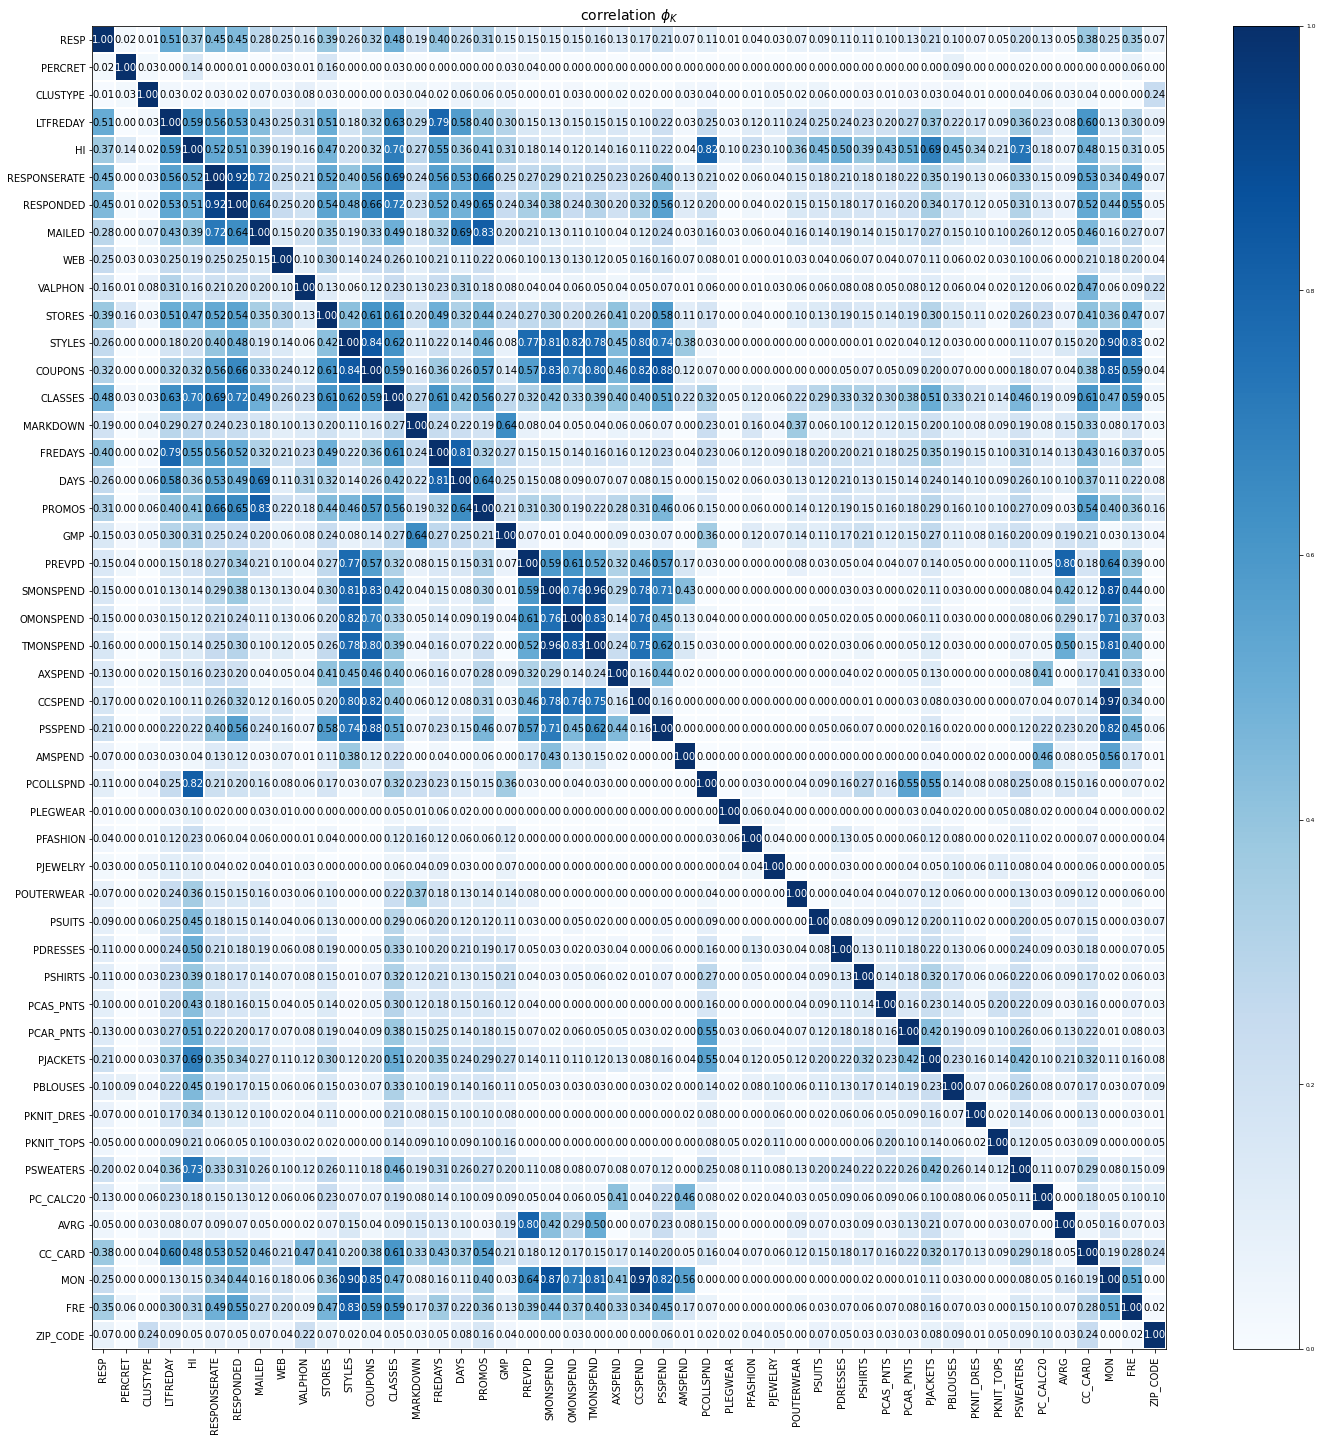

In [ ]:
# Code from https://colab.research.google.com/github/KaveIO/PhiK/blob/master/phik/notebooks/phik_tutorial_basic.ipynb

phik_overview = train_fashion.phik_matrix()

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(20, 20))
plt.tight_layout()

In [ ]:
# Phi k score with response variables sorted
train_fashion.phik_matrix()['RESP'].sort_values(ascending = False)

interval columns not set, guessing: ['ZIP_CODE', 'FRE', 'MON', 'CC_CARD', 'AVRG', 'PC_CALC20', 'PSWEATERS', 'PKNIT_TOPS', 'PKNIT_DRES', 'PBLOUSES', 'PJACKETS', 'PCAR_PNTS', 'PCAS_PNTS', 'PSHIRTS', 'PDRESSES', 'PSUITS', 'POUTERWEAR', 'PJEWELRY', 'PFASHION', 'PLEGWEAR', 'PCOLLSPND', 'AMSPEND', 'PSSPEND', 'CCSPEND', 'AXSPEND', 'TMONSPEND', 'OMONSPEND', 'SMONSPEND', 'PREVPD', 'GMP', 'PROMOS', 'DAYS', 'FREDAYS', 'MARKDOWN', 'CLASSES', 'COUPONS', 'STYLES', 'STORES', 'VALPHON', 'WEB', 'MAILED', 'RESPONDED', 'RESPONSERATE', 'HI', 'LTFREDAY', 'CLUSTYPE', 'PERCRET', 'RESP']


RESP            1.000000
LTFREDAY        0.511814
CLASSES         0.481269
RESPONSERATE    0.451168
RESPONDED       0.449792
FREDAYS         0.401248
STORES          0.385170
CC_CARD         0.380003
HI              0.373505
FRE             0.347962
COUPONS         0.315987
PROMOS          0.313985
MAILED          0.283741
STYLES          0.259972
DAYS            0.259455
WEB             0.250610
MON             0.245578
PSSPEND         0.213424
PJACKETS        0.213360
PSWEATERS       0.204123
MARKDOWN        0.192586
CCSPEND         0.165814
VALPHON         0.164216
TMONSPEND       0.158753
SMONSPEND       0.154544
GMP             0.150788
PREVPD          0.147718
OMONSPEND       0.145541
PCAR_PNTS       0.131966
PC_CALC20       0.131258
AXSPEND         0.130956
PSHIRTS         0.108509
PDRESSES        0.107200
PCOLLSPND       0.105130
PBLOUSES        0.099410
PCAS_PNTS       0.096936
PSUITS          0.092267
POUTERWEAR      0.074442
ZIP_CODE        0.072585
PKNIT_DRES      0.067361


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass t

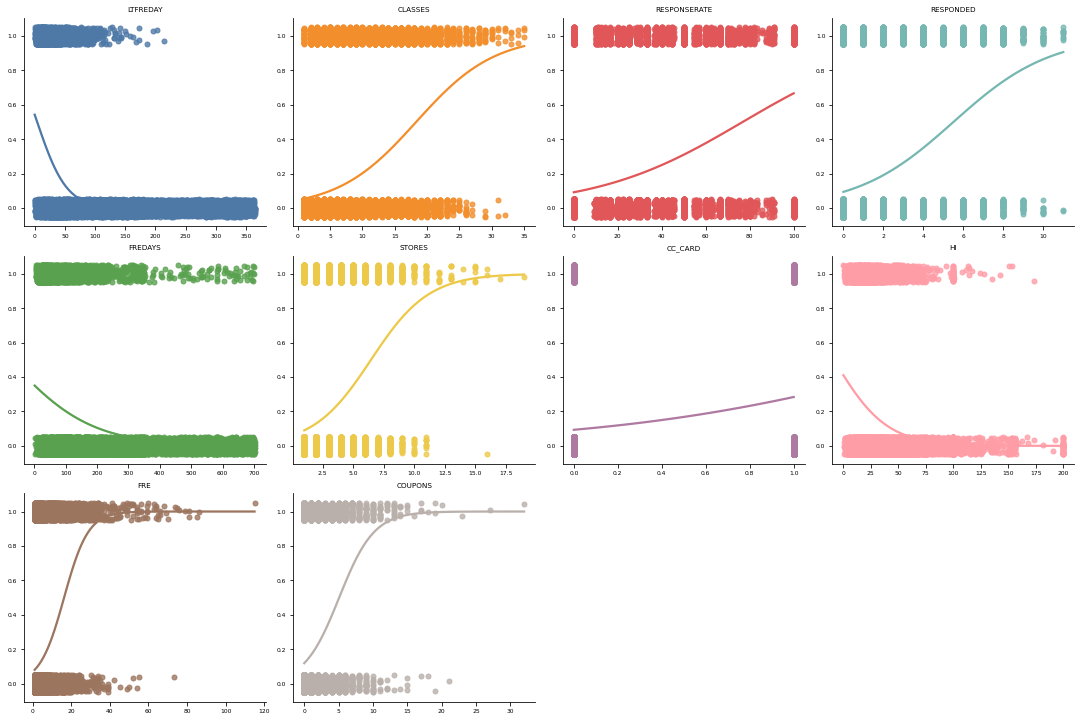

In [ ]:
high_correl = ['LTFREDAY', 'CLASSES', 'RESPONSERATE', 'RESPONDED', 'FREDAYS', 'STORES', 'CC_CARD', 'HI', 'FRE', 'COUPONS']
    
def plotregressions(X, y, logistic=False):
    # X should be a pandas dataframe
    
    colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']

    # Feature names
    labels = list(X.columns)
    
    n, p = X.shape
    
    # We want three plots per column, calculate the required number of rows accordingly
    rows = int(np.ceil(p/4)) 
    
    # Create a plot grid
    fig, axes = plt.subplots(rows, 4, figsize=(15, rows*(10/3)))

    # Loop over the plot grid, create 
    for i, ax in enumerate(fig.axes):
        if i < p:
            
            # Scatter plot with local smoothing
            sns.regplot(X.iloc[:, i], y,  ci=None, y_jitter=0.05, 
                        scatter_kws={'s': 25, 'alpha':.8}, ax=ax, logistic=logistic, color=colours[i % 10])
            
            # Remove axis labels to de-clutter the plot
            ax.set_xlabel('')
            ax.set_ylabel('')
            
            # Manually set the limits for the horizontal axis since the default doesn't work so well
            xmin = X.iloc[:,i].min()
            xmax = X.iloc[:,i].max()
            ax.set_xlim(xmin - (xmax-xmin)*0.05, xmax + (xmax - xmin)*0.05)
            
            # Use the feature name for the title
            ax.set_title(labels[i])
        
        else:
            # Delete unnecessary subplots (last row)
            fig.delaxes(ax)

    sns.despine()
    plt.tight_layout()
    
    return fig, axes

plotregressions(train_fashion[high_correl], train_fashion['RESP'], logistic=True)
plt.show()

## Feature Engineering

In [ ]:
# Transforming features

train_fashion2 = train_fashion.copy()
test_fashion2 = test_fashion.copy()

# Specify variable for transformation
not_transformed = ['GMP', 'DAYS', 'MARKDOWN', 'ZIP_CODE', 'PROMOS', 'MAILED']
feature_transform = discrete + continuous
pos_skew = [x for x in feature_transform if x not in not_transformed]

print(pos_skew)

['FRE', 'PC_CALC20', 'FREDAYS', 'CLASSES', 'COUPONS', 'STYLES', 'STORES', 'RESPONDED', 'MON', 'AVRG', 'PSWEATERS', 'PKNIT_TOPS', 'PKNIT_DRES', 'PBLOUSES', 'PJACKETS', 'PCAR_PNTS', 'PCAS_PNTS', 'PSHIRTS', 'PDRESSES', 'PSUITS', 'POUTERWEAR', 'PJEWELRY', 'PFASHION', 'PLEGWEAR', 'PCOLLSPND', 'AMSPEND', 'PSSPEND', 'CCSPEND', 'AXSPEND', 'TMONSPEND', 'OMONSPEND', 'SMONSPEND', 'PREVPD', 'RESPONSERATE', 'HI', 'LTFREDAY', 'PERCRET']


In [ ]:
# Log transformation for positive skewed data
train_fashion2[pos_skew] = train_fashion2[pos_skew].replace(0,0.000001)
test_fashion2[pos_skew] = test_fashion2[pos_skew].replace(0,0.000001)

train_fashion2[pos_skew] = train_fashion2[pos_skew].apply(np.log)
test_fashion2[pos_skew] = test_fashion2[pos_skew].apply(np.log)

In [ ]:
# Check the skewness and kurtosis after log transformation

skew_cont2 = list(train_fashion2[continuous].skew())
kurt_cont2 = list(train_fashion2[continuous].kurtosis())

cont_info2 = pd.DataFrame(zip(skew_cont, skew_cont2, kurt_cont, kurt_cont2), columns=['Skewness(before)',
                                                                                      'Skewness (after)',
                                                                                      'Kurtosis (before)',
                                                                                      'Kurtosis (after'], index = continuous)
cont_info2

,Skewness(before),Skewness (after),Kurtosis (before),Kurtosis (after
MON,7.0641,0.252020,129.6889,0.070914
AVRG,3.6814,-0.205606,31.8600,1.108953
PSWEATERS,1.5134,-1.019636,2.2864,-0.879989
PKNIT_TOPS,6.1606,0.578490,60.1322,-1.601738
PKNIT_DRES,4.4911,0.906139,25.6006,-1.110426
PBLOUSES,2.6896,-0.289192,10.6466,-1.866027
PJACKETS,1.5521,-0.045716,2.4989,-1.967429
PCAR_PNTS,2.4623,0.188145,8.0406,-1.929220
PCAS_PNTS,3.0479,0.339846,11.9604,-1.833976
PSHIRTS,2.9351,0.273369,12.3505,-1.885327


In [ ]:
skew_disc2 = list(train_fashion2[discrete].skew())
kurt_disc2 = list(train_fashion2[discrete].kurtosis())

disc_info2 = pd.DataFrame(zip(skew_disc, skew_disc2, kurt_disc, kurt_disc2), columns=['Skewness(before)',
                                                                'Skewness (after)',
                                                                'Kurtosis (before)',
                                                                'Kurtosis (after'], index = discrete)
disc_info2

,Skewness(before),Skewness (after),Kurtosis (before),Kurtosis (after
ZIP_CODE,0.0155,0.015524,-0.8094,-0.809380
FRE,4.2138,0.485190,29.8248,-0.476716
PC_CALC20,1.0411,0.983115,-0.6206,-0.865735
PROMOS,0.1610,0.160988,-0.9149,-0.914863
DAYS,-0.2349,-0.234929,-1.1624,-1.162432
FREDAYS,1.6000,-0.246881,2.3988,-0.183532
CLASSES,1.3113,-0.235814,1.6491,-0.522817
COUPONS,4.4659,0.781857,32.6131,-1.372176
STYLES,5.7854,0.214240,73.5118,-0.285994
STORES,2.2303,0.424448,8.2153,-0.556705


In [ ]:
# Delete unnecessary variables and variables with high multicollinearity

remove_col = ['ZIP_CODE', 'FREDAYS', 'RESPONDED', 'TMONSPEND', 'OMONSPEND', 'GMP']

train_fashion2 = train_fashion2.drop(remove_col, axis=1)
test_fashion2 = test_fashion2.drop(remove_col, axis=1)

In [ ]:
# Set variables

X_train = train_fashion2.loc[:, train_fashion2.columns != 'RESP']
X_test = test_fashion2.loc[:, test_fashion2.columns != 'RESP']

y_train = train_fashion2[response]
y_test = test_fashion2[response]

## Loss matrix
We define the loss matrix using inverse class probabilities as the dataset has imbalanced proportion between class 0 and 1. We assume that the dataset represents the reality.

<table>
  <tr>
    <th>Actual/ Predicted</th>
    <th>Did not respond (0)</th>
     <th>Responded (1)</th>
  </tr>
  <tr>
    <th>Did not respond (0)</th>
    <td>0</td>
    <td>17</td>
  </tr>
  <tr>
    <th>Responded (1)</th>
    <td>83</td>
    <td>0</td>
  </tr>
</table>

In [ ]:
tau = 17/(17+83)
print(f'Decision threshold: tau={round(tau,3)}')

Decision threshold: tau=0.17


## Train the models
### 1. Logistic Regression

In [ ]:
logit_l1= LogisticRegressionCV(penalty='l1', solver='liblinear', scoring='average_precision')
logit_l1.fit(X_train, y_train.values.ravel())

LogisticRegressionCV(penalty='l1', scoring='average_precision',
                     solver='liblinear')

In [ ]:
# Check how many variables with coefficient 0

np.sum(np.abs(logit_l1.coef_) == 0.0)

0

In [ ]:
# Show coefficient for each feature

logit_coef = pd.DataFrame(zip(X_train.columns, np.transpose(logit_l1.coef_).round(3)), columns=['features', 'coef']).sort_values('coef') 

logit_coef2 = logit_coef[logit_coef.coef != 0]
logit_coef2

,features,coef
38,LTFREDAY,[-1.58]
28,MARKDOWN,[-0.655]
32,STORES,[-0.143]
29,CLASSES,[-0.08]
35,MAILED,[-0.052]
31,STYLES,[-0.027]
37,HI,[-0.023]
9,PJACKETS,[-0.017]
21,PSSPEND,[-0.014]
30,COUPONS,[-0.012]


In [ ]:
# Create blank list to store all auc-roc score
model = []
auprc = []

In [ ]:
# Calculate AUPRC score
%%time
auprc_logit_l1 = np.mean(cross_val_score(logit_l1, X_train, y_train.values.ravel(), scoring='average_precision', cv=5))

model.append('Logistic Regression')
auprc.append(auprc_logit_l1)

CPU times: user 2min 51s, sys: 3.69 s, total: 2min 54s
Wall time: 2min 50s


### 2. KNN

In [ ]:
predictors = ['LTFREDAY', 'CLASSES', 'RESPONSERATE', 'STORES', 'CC_CARD', 'HI', 'FRE', 'COUPONS' ]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train[predictors], y_train.values.ravel())

KNeighborsClassifier(n_neighbors=30)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid
# Code referenced from https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning/notebook
grid_params = { 'n_neighbors' : np.arange (1, 50),
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

# Run the grid search
knn_search =  GridSearchCV(KNeighborsClassifier(), grid_params, cv = 3,  scoring = 'average_precision', verbose=1)
knn_search.fit(X_train[predictors], y_train.values.ravel())

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'weights': ['uniform', 'distance']},
             scoring='average_precision', verbose=1)

In [ ]:
knn_search.best_params_

{'metric': 'minkowski', 'n_neighbors': 47, 'weights': 'distance'}

In [ ]:
knn = KNeighborsClassifier(n_neighbors=47, weights = 'distance', algorithm = 'brute', metric = 'minkowski')
knn.fit(X_train[predictors], y_train.values.ravel())

KNeighborsClassifier(algorithm='brute', n_neighbors=47, weights='distance')

In [ ]:
%%time
auprc_knn = np.mean(cross_val_score(knn, X_train, y_train.values.ravel(), scoring='average_precision', cv=5))

model.append('KNN (k=47)')
auprc.append(auprc_knn)

CPU times: user 6.26 s, sys: 571 ms, total: 6.83 s
Wall time: 5.38 s


### 3. Boosting

In [ ]:
import lightgbm as lgb

# Reconstruct the dataset to tune min_data_in_leaf
train_data = lgb.Dataset(X_train, y_train, categorical_feature = 'auto')

# Code referenced from tutorial 10 and https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_simple.py
def objective(trial):
    
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10), 
        'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
        }
    
    # Cross-validation 
    history = lgb.cv(params, train_data, num_boost_round = 5000, 
                 nfold = 5, stratified = False, early_stopping_rounds = 50, verbose_eval=0)
    
    # Save full set of parameters
    trial.set_user_attr('params', params)
    
    # Save the number of boosting iterations selected by early stopping
    trial.set_user_attr('num_boost_round', len(history['binary_logloss-mean']))
    
    return history['binary_logloss-mean'][-1]

sampler = TPESampler(seed = 42) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=1000, timeout = 180)  

[I 2022-05-27 03:30:17,493] A new study created in memory with name: no-name-e45dbf27-c78b-4115-a253-39de420ad36d
[I 2022-05-27 03:30:23,950] Trial 0 finished with value: 0.345126636960747 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403, 'num_leaves': 188, 'bagging_fraction': 0.7993292420985183, 'bagging_freq': 2, 'feature_fraction': 0.5779972601681014, 'min_child_samples': 10}. Best is trial 0 with value: 0.345126636960747.
[I 2022-05-27 03:30:29,034] Trial 1 finished with value: 0.3413136155357233 and parameters: {'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'num_leaves': 182, 'bagging_fraction': 0.5102922471479012, 'bagging_freq': 10, 'feature_fraction': 0.9162213204002109, 'min_child_samples': 25}. Best is trial 1 with value: 0.3413136155357233.
[I 2022-05-27 03:30:32,791] Trial 2 finished with value: 0.3405310753367924 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07, 'num_leaves': 

In [ ]:
params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
params 

Number of boosting iterations: 200 

Best parameters:


{'bagging_fraction': 0.6403804771198521,
 'bagging_freq': 1,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.9623808979969584,
 'lambda_l1': 0.00551754389510454,
 'lambda_l2': 1.5424453791571902e-08,
 'metric': 'binary_logloss',
 'min_child_samples': 86,
 'num_leaves': 3,
 'objective': 'binary',
 'verbosity': -1}

In [ ]:
lgbm = lgb.LGBMClassifier(objective='binary',
                          bagging_fraction= 0.6403804771198521,
                          bagging_freq= 1,
                          boosting_type= 'gbdt',
                          feature_fraction= 0.9623808979969584,
                          feature_pre_filter= False,
                          lambda_l1= 0.00551754389510454,
                          lambda_l2= 1.5424453791571902e-08,
                          min_child_samples= 86,
                          num_leaves= 3,
                          verbosity= -1)

lgbm = lgbm.fit(X_train, y_train.values.ravel())

In [ ]:
%%time

auprc_lgbm = np.mean(cross_val_score(lgbm, X_train, y_train.values.ravel(), scoring='average_precision', cv=5))

model.append('LightGBM')
auprc.append(auprc_lgbm)

CPU times: user 2.58 s, sys: 21.9 ms, total: 2.6 s
Wall time: 1.4 s


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


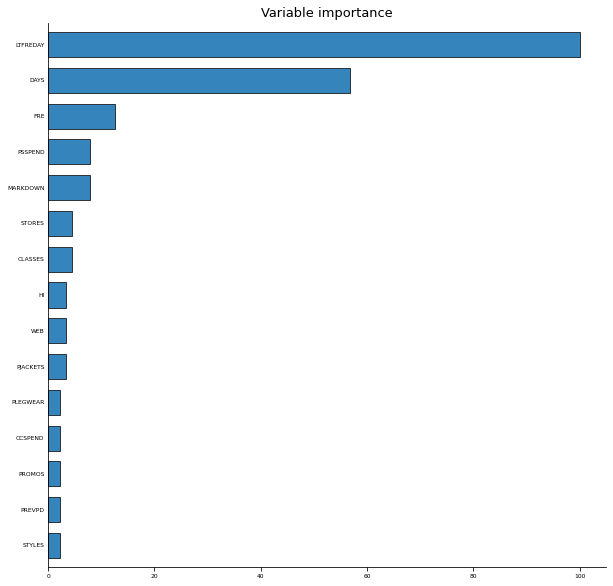

In [ ]:
# Plot feature importance

def plot_feature_importance(model, labels, max_features = 15):
    feature_importance = model.feature_importances_*100
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(10,10))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Variable importance', fontsize=13)
    sns.despine()
    sns.set(font_scale=0.5)
    return fig, ax

plot_feature_importance(lgbm, list(X_train.columns))
plt.show()

In [ ]:
# Get SHAP values for LightGBM
shap.initjs()

explainer_lgbm = shap.Explainer(lgbm)
shap_values_lgbm = explainer_lgbm.shap_values(X_train.iloc[:1000, :])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


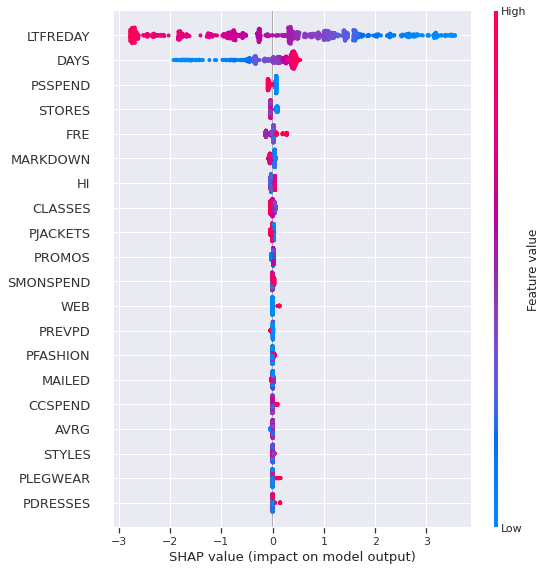

In [ ]:
shap.summary_plot(shap_values_lgbm[1], X_train.iloc[:1000, :])

## 4. Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def objective(trial):
    
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_int('max_features', 1, 20)
    
    
    model = RandomForestClassifier(n_estimators = 100,  
                                  criterion = criterion,  
                                  max_features = max_features, 
                                  min_samples_leaf= min_samples_leaf,
                                  random_state = 1)
    
    scores = cross_val_score(model, X_train, y_train.values.ravel(), cv = 5, scoring = 'average_precision')
    loss = 1 - np.mean(scores)
    
    return loss

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials = 1000, timeout = 300)

[I 2022-05-27 03:33:27,213] A new study created in memory with name: no-name-3f04b8f5-cb66-4e69-ac18-b5ebd03693de
[I 2022-05-27 03:33:51,452] Trial 0 finished with value: 0.4665540018805533 and parameters: {'criterion': 'gini', 'min_samples_leaf': 15, 'max_features': 12}. Best is trial 0 with value: 0.4665540018805533.
[I 2022-05-27 03:34:58,356] Trial 1 finished with value: 0.4736416847094995 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 2, 'max_features': 18}. Best is trial 1 with value: 0.4736416847094995.
[I 2022-05-27 03:35:54,353] Trial 2 finished with value: 0.4898562210158134 and parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 20}. Best is trial 2 with value: 0.4898562210158134.
[I 2022-05-27 03:36:10,525] Trial 3 finished with value: 0.48366331617714897 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 4, 'max_features': 4}. Best is trial 2 with value: 0.4898562210158134.
[I 2022-05-27 03:36:25,381] Trial 4 finished with value

In [ ]:
params = study.best_params
params

{'criterion': 'gini', 'max_features': 20, 'min_samples_leaf': 1}

In [ ]:
rf =  RandomForestClassifier(n_estimators=100,  criterion='gini',  max_features = 20, min_samples_leaf= 1)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_features=20)

In [ ]:
%%time
auprc_rf = np.mean(cross_val_score(rf, X_train, y_train.values.ravel(), scoring='average_precision', cv=5))

model.append('Random Forest')
auprc.append(auprc_rf)

CPU times: user 54.2 s, sys: 66.2 ms, total: 54.2 s
Wall time: 54 s


In [ ]:
# Get SHAP values for Random Forest

shap.initjs()

explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(X_train.iloc[:1000, :])

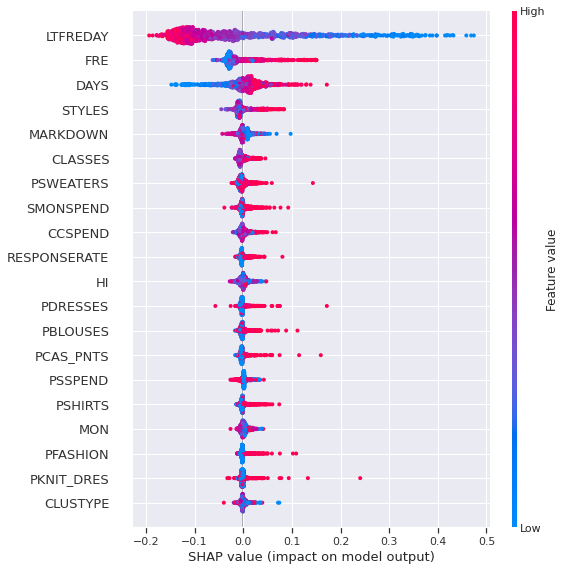

In [ ]:
shap.summary_plot(shap_values[1], X_train.iloc[:1000, :])

### 5. Model stacking

In [ ]:
%%time
stack = StackingClassifier(estimators = [('Logistic Regression', logit_l1), ('LightGBM', lgbm)], final_estimator = LogisticRegression(), 
                           stack_method = 'auto', cv = 5)

stack.fit(X_train, y_train.values.ravel())

CPU times: user 3min 30s, sys: 4.48 s, total: 3min 35s
Wall time: 3min 27s


In [ ]:
stack.final_estimator_.coef_

array([[2.14625962, 4.4510953 ]])

In [ ]:
%%time

auprc_stack = np.mean(cross_val_score(stack, X_train, y_train.values.ravel(), scoring='average_precision', cv=5))

model.append('Model Stacking')
auprc.append(auprc_stack)

CPU times: user 14min 28s, sys: 22.1 s, total: 14min 51s
Wall time: 14min 16s


In [ ]:
%%time
stack2 = StackingClassifier(estimators = [('Logistic Regression', logit_l1), ('Random Forest', rf)], final_estimator = LogisticRegression(), 
                           stack_method = 'auto', cv = 5)

stack2.fit(X_train, y_train.values.ravel())

CPU times: user 4min 38s, sys: 4.56 s, total: 4min 43s
Wall time: 4min 36s


In [ ]:
stack2.final_estimator_.coef_

array([[3.58464017, 2.90268325]])

In [ ]:
%%time

auprc_stack2 = np.mean(cross_val_score(stack2, X_train, y_train.values.ravel(), scoring='average_precision', cv=5))

model.append('Model Stacking 2')
auprc.append(auprc_stack2)

CPU times: user 18min 16s, sys: 22.6 s, total: 18min 38s
Wall time: 18min 8s


## Model selection and evaluation

In [ ]:
# Create a table comparing AUPRC score from all models

auprc_all = pd.DataFrame(auprc, columns=['AUPRC score'], index = model)
auprc_all

,AUPRC score
Logistic Regression,0.529542
KNN (k=47),0.384126
LightGBM,0.542236
Random Forest,0.512811
Model Stacking,0.545011
Model Stacking 2,0.536371


In [ ]:
# Prediction score

from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, log_loss, average_precision_score

columns=['Sensitivity', 'Specificity', 'Precision', 'AUC-ROC', 'AUPRC']
rows=['Logistic Regression', 'KNN (k=49)', 'LightGBM', 'Random Forest', 'Stack', 'Stack 2']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit_l1, knn, lgbm, rf, stack, stack2]

y_test = np.ravel(y_test)
y_prob = np.zeros((len(y_test), len(rows)))

for i, method in enumerate(methods):    
    if method == knn:
      y_prob[:,i] = method.predict_proba(X_test[predictors])[:,1]
      y_pred = (y_prob[:,i] > tau).astype(int)
    else:
          y_prob[:,i] = method.predict_proba(X_test)[:,1]
          y_pred = (y_prob[:,i] > tau).astype(int)

    loss =  83*((y_pred!=y_test) & (y_pred==0)) + 17*((y_pred!=y_test) & (y_pred==1))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

    results.iloc[i,0] =  tp/(tp+fn)
    results.iloc[i,1] =  tn/(tn+fp)
    results.iloc[i,2] =  precision_score(y_test, y_pred)
    results.iloc[i,3] =  roc_auc_score(y_test, y_prob[:,i])
    results.iloc[i,4] =  average_precision_score(y_test, y_prob[:,i])
    
results.round(3)

,Sensitivity,Specificity,Precision,AUC-ROC,AUPRC
Logistic Regression,0.785,0.739,0.374,0.844,0.514
KNN (k=49),0.792,0.690,0.337,0.823,0.490
LightGBM,0.835,0.711,0.365,0.850,0.539
Random Forest,0.837,0.677,0.340,0.838,0.517
Stack,0.713,0.802,0.417,0.850,0.536
Stack 2,0.697,0.805,0.416,0.845,0.530
